In [1]:
import numpy as np
#import matplotlib
#matplotlib.use('Agg');
import matplotlib.pyplot as plt
#plt.set_cmap('jet');
import random, os, sys, pandas, os, pickle
import pandas as pd
import argparse
from textwrap import wrap
%matplotlib inline
import glob
import seaborn as sns
from copy import copy

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Collects all of the results available in logs-single.
all_df = []
#ddf = pandas.DataFrame()
for f in glob.glob("../logs-single/*/stats/metrics.pkl"):
    d = pickle.load(open(f,"rb"))
    all_df.append(pandas.DataFrame.from_dict(d))

df = pandas.concat(all_df)

In [10]:
# Clean out the dataframe.
KEEP = ["auc", "best", "recon_lambda", "actdiff_lambda", "epoch", "name", "maxmasks"]
for col in df.columns:
    if not any([string in col for string in KEEP]):
        del df[col]

# Experiment name is determined by the configuration file used.
experiments = df.experiment_name.unique()

print("resulting df \nshape={} tracking {} experiments, \ncolumns={}".format(
    df.shape, len(experiments), df.columns))

resulting df 
shape=(1202505, 14) tracking 72 experiments, 
columns=Index(['actdiff_lambda', 'best_epoch', 'best_test_auc', 'best_train_auc',
       'best_valid_auc', 'epoch', 'experiment_name', 'maxmasks_train',
       'num_epochs', 'recon_lambda', 'test_auc', 'train_auc',
       'train_dataset_maxmasks', 'valid_auc'],
      dtype='object')


In [11]:
# Split the dataframes into baseline and n_mask experiments.
df_synth = df[df['experiment_name'].str.contains('synth_')]
df_liver = df[df['experiment_name'].str.contains('livermsd_')]
df_cardiac = df[df['experiment_name'].str.contains('cardiacmsd_')]
df_pancreas = df[df['experiment_name'].str.contains('pancreasmsd_')]
df_baseline = pd.concat([df_synth, df_liver, df_cardiac, df_pancreas], axis=0)

df_synth_mask = df[df['experiment_name'].str.contains('synth-masks')]
df_liver_mask = df[df['experiment_name'].str.contains('livermsd-masks')]
df_cardiac_mask = df[df['experiment_name'].str.contains('cardiacmsd-masks')]
df_pancreas_mask = df[df['experiment_name'].str.contains('pancreasmsd-masks')]
df_mask = pd.concat([df_synth_mask, df_liver_mask, df_cardiac_mask, df_pancreas_mask], axis=0)


EPOCH=499

In [37]:
# Uses the control experiments (no activmask) as the "maxmasks=0" runs for the maxmasks plots below.
tmp_resnet = df_synth[df_synth['experiment_name'] == 'synth_resnet']
tmp_resnet['experiment_name'] = 'synth-masks_resnet_actdiff'
tmp_resnet['maxmasks_train'] = 0
tmp_unet = df_synth[df_synth['experiment_name'] == 'synth_unet']
tmp_unet['experiment_name'] = 'synth-masks_unet_actdiff'
tmp_unet['maxmasks_train'] = 0
df_synth_mask = pandas.concat([df_synth_mask, tmp_resnet, tmp_unet])

tmp_resnet = df_liver[df_liver['experiment_name'] == 'livermsd_resnet']
tmp_resnet['experiment_name'] = 'livermsd-masks_resnet_actdiff'
tmp_resnet['maxmasks_train'] = 0
tmp_unet = df_liver[df_liver['experiment_name'] == 'livermsd_unet']
tmp_unet['experiment_name'] = 'livermsd-masks_unet_actdiff'
tmp_unet['maxmasks_train'] = 0
df_liver_mask = pandas.concat([df_liver_mask, tmp_resnet, tmp_unet])

tmp_resnet = df_cardiac[df_cardiac['experiment_name'] == 'cardiacmsd_resnet']
tmp_resnet['experiment_name'] = 'cardiacmsd-masks_resnet_actdiff'
tmp_resnet['maxmasks_train'] = 0
tmp_unet = df_cardiac[df_cardiac['experiment_name'] == 'cardiacmsd_unet']
tmp_unet['experiment_name'] = 'cardiacmsd-masks_unet_actdiff'
tmp_unet['maxmasks_train'] = 0
df_cardiac_mask = pandas.concat([df_cardiac_mask, tmp_resnet, tmp_unet])

tmp_resnet = df_pancreas[df_pancreas['experiment_name'] == 'pancreasmsd_resnet']
tmp_resnet['experiment_name'] = 'pancreasmsd-masks_resnet_actdiff'
tmp_resnet['maxmasks_train'] = 0
tmp_unet = df_pancreas[df_pancreas['experiment_name'] == 'pancreasmsd_unet']
tmp_unet['experiment_name'] = 'pancreasmsd-masks_unet_actdiff'
tmp_unet['maxmasks_train'] = 0
df_pancreas_mask = pandas.concat([df_pancreas_mask, tmp_resnet, tmp_unet])


In [12]:
"""A collection of plotting functions used below. Not all in use at the minute."""

def get_results_at_epoch(df, epoch, groups, cols, count=False):
    """
    Shows a reduced form of the table with mean and std values 
    over experiments.
    """
    df_tmp = df[(df.epoch==epoch)].groupby(groups)[cols]
    df = df_tmp.mean().join(df_tmp.std(),rsuffix='_std')
    if count:
        df = df.join(df_tmp.count(), rsuffix='_count')
                                                                        
    return df


def get_last_results_at_epoch(df, epoch):
    """Get the train/test/valid AUC at the final, not best, epoch."""
    #groups = ['experiment_name', 'actdiff_lambda', 'recon_lambda']
    groups = ['experiment_name']
    cols = ['train_auc', 'valid_auc', 'best_epoch']
    
    return get_results_at_epoch(df, epoch, groups, cols)


def get_best_results_at_epoch(df, epoch):
    """Get the test results at the best epoch."""
    groups = ['experiment_name']
    cols = ['best_test_auc']
    
    return get_results_at_epoch(df, epoch, groups, cols)


def get_all_best_results_at_epoch(dfs, epoch):
    """
    Merge the best test results for all dataframes submitted. 
    Used to make a results table across datasets.
    """
    for i, df in enumerate(dfs):
        tmp_df = copy(df)
        
        # Strip the dataset name out of the experiment name.        
        name = tmp_df['experiment_name'].iloc[0].split('_')[0]
        tmp_df['experiment_name'] = tmp_df['experiment_name'].str.replace('{}_'.format(name), '')
        
        # Reformat the table.
        tmp_df = get_best_results_at_epoch(tmp_df, epoch)

        # Put the experiment name in the name for the AUC metric.
        tmp_df = tmp_df.rename({'best_test_auc': 'test_auc_{}'.format(name), 
                                'best_test_auc_std': 'test_auc_std_{}'.format(name)}, axis=1)

        # Merge the experiments.
        if i == 0:
            final_df = copy(tmp_df)
        else:
            final_df = pd.merge(final_df, tmp_df, on='experiment_name')
    
    return final_df


def get_mask_results_at_epoch(df, epoch):
    """
    Get the results of the maxmask experiments at a given epoch. Not used currently.
    """
    groups = ["experiment_name", "epoch", "train_dataset_maxmasks"]
    cols = ["best_test_auc", "best_epoch"]
    
    return get_results_at_epoch(df, epoch, groups, cols)


def get_plot_df(input_df, epoch):
    """
    Gets a dataframe useful for the boxplots below.
    """
    df = copy(input_df)
    df = df[(df.epoch==EPOCH)]
    idx = ~df['experiment_name'].str.contains('cnn')
    df = df[idx]
    idx = ~df['experiment_name'].str.contains('_ae_')
    return df[idx]


def plot_curves(df, mode='test'):
    """Plots the test AUC over epochs for an experiment table."""
    EPOCH = 499
    EXPERIMENTS = ['unet', 'ae', 'resnet', 'cnn']
    EXP_NAMES = ["UNet", "Autoencoder", "ResNet 18", "ConvNet"]

    assert mode in ['test', 'train', 'valid']
    
    fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)
    ax = ax.ravel()
    
    for i, (exp, exp_name) in enumerate(zip(EXPERIMENTS, EXP_NAMES)):
        
        ls = ['solid', 'dashed', 'dashdot', 'dotted', '-' ,'--' ,'-.' , ':','None' ,' ' ,'' ]
        dfs = df.reindex()

        # Filter by experiment.
        dfs = dfs[dfs['experiment_name'].str.contains(exp)]

        for j, name in enumerate(sorted(dfs.experiment_name.unique())):
 
            thisdata = dfs[dfs["experiment_name"] == name]
            willplot = thisdata.groupby(["epoch"]).mean()
            r = willplot.plot(y="{}_auc".format(mode), 
                              ax=ax[i], label=name, ls=ls[j])

        patches, labels = ax[i].get_legend_handles_labels()
 
        ax[i].legend(patches, labels, loc='lower right', title="experiment")    
        ax[i].set_ylim(-0.05, 1.05)  
        ax[i].set_ylabel("AUC")  
        ax[i].set_xlabel("Epoch")

        ax[i].set_title("{} Experiments".format(exp_name))
        fig.set_tight_layout(tight=True)

In [139]:
# Write table showing the results at the final epoch.
with open('tables/synth_last_results.tex','w') as tf:
    tf.write(get_last_results_at_epoch(df_synth, EPOCH).to_latex())

In [237]:
# Write table showing best test AUC results.
with open('tables/all_test_results.tex', 'w') as tf:
    tf.write(get_all_best_results_at_epoch([df_synth, df_liver, df_cardiac, df_pancreas], EPOCH).to_latex())

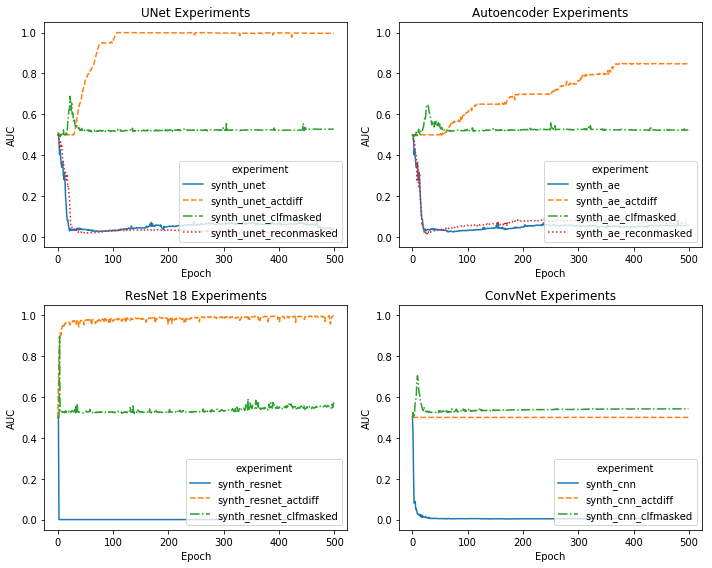

In [11]:
plot_curves(df_synth, mode='valid')

In [12]:
# Perhaps useful?
# plot_curves(df_liver)
# plot_curves(df_cardiac)
# plot_curves(df_pancreas)

In [13]:
# Also, maybe useful.
#get_best_results_at_epoch(df_synth, EPOCH)
#get_best_results_at_epoch(df_liver, EPOCH)
#get_best_results_at_epoch(df_cardiac, EPOCH)
#get_best_results_at_epoch(df_pancreas, EPOCH)

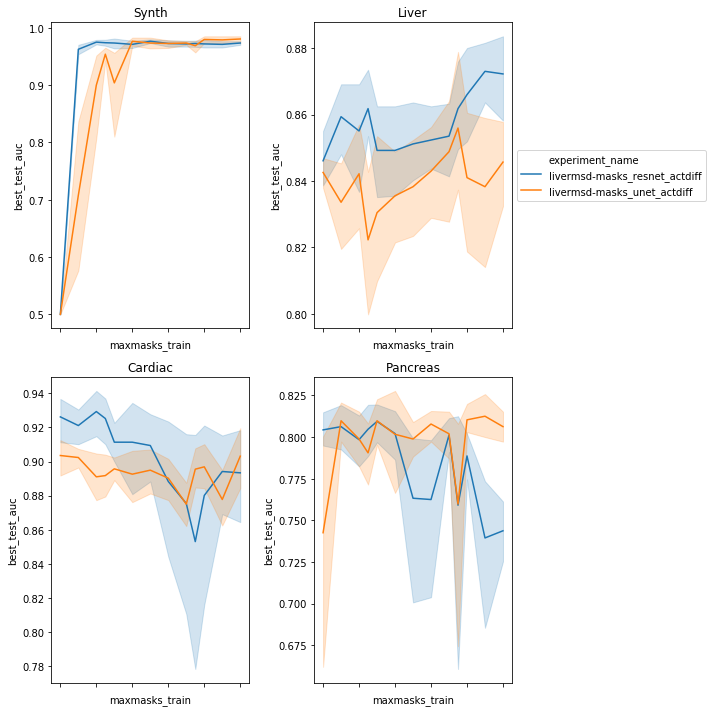

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10,10), nrows=2, ncols=2)

g = sns.lineplot(
    x="maxmasks_train", y='best_test_auc', hue='experiment_name', 
    ax=ax1, data=get_plot_df(df_synth_mask, EPOCH))
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
g.set_title("Synth")
g.get_legend().remove()

g = sns.lineplot(
    x="maxmasks_train", y='best_test_auc', hue='experiment_name', 
    ax=ax2, data=get_plot_df(df_liver_mask, EPOCH))
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
g.set_title("Liver")
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

g = sns.lineplot(
    x="maxmasks_train", y='best_test_auc', hue='experiment_name', 
    ax=ax3, data=get_plot_df(df_cardiac_mask, EPOCH))
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
g.set_title("Cardiac")
g.get_legend().remove()

g = sns.lineplot(
    x="maxmasks_train", y='best_test_auc', hue='experiment_name', 
    ax=ax4, data=get_plot_df(df_pancreas_mask, EPOCH))
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
g.set_title("Pancreas")
g.get_legend().remove()


fig.set_tight_layout(tight=True)

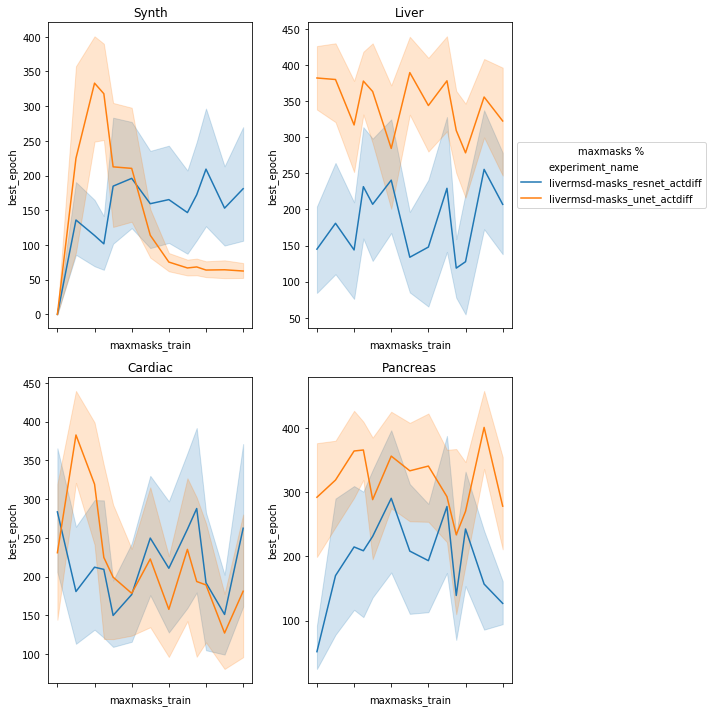

In [41]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10,10), nrows=2, ncols=2)

g = sns.lineplot(
    x="maxmasks_train", y='best_epoch', hue='experiment_name', 
    ax=ax1, data=get_plot_df(df_synth_mask, EPOCH))
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
g.set_title("Synth")
g.get_legend().remove()

g = sns.lineplot(
    x="maxmasks_train", y='best_epoch', hue='experiment_name', 
    ax=ax2, data=get_plot_df(df_liver_mask, EPOCH))
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
g.set_title("Liver")
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='maxmasks %')

g = sns.lineplot(
    x="maxmasks_train", y='best_epoch', hue='experiment_name', 
    ax=ax3, data=get_plot_df(df_cardiac_mask, EPOCH))
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
g.set_title("Cardiac")
g.get_legend().remove()

g = sns.lineplot(
    x="maxmasks_train", y='best_epoch', hue='experiment_name', 
    ax=ax4, data=get_plot_df(df_pancreas_mask, EPOCH))
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
g.set_title("Pancreas")
g.get_legend().remove()

fig.set_tight_layout(tight=True)